In [ ]:
# STEP 1: INSTALL LIBRARIES
!pip install librosa scikit-learn soundfile --quiet

In [ ]:
# STEP 2: IMPORT LIBRARIES
import os
import numpy as np
import librosa
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import files
import soundfile as sf
import shutil

In [ ]:
# STEP 3: FEATURE EXTRACTION FUNCTION (MFCC)
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        return np.mean(mfcc.T, axis=0)
    except Exception as e:
        print(f"Feature extraction failed for {file_path}: {e}")
        return None

In [ ]:
# STEP 4: CLEAN OLD FOLDERS AND CREATE NEW ONES
for folder in ["enroll", "test"]:
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.makedirs(folder)
print("Folders Ready: enroll, test")

Folders Ready: enroll, test


In [ ]:
# STEP 5: ENROLL USERS (Upload known speakers)
print("Upload 2–3 audio files for ENROLLMENT")
enroll_files = files.upload()

enroll_embeddings = []
enroll_labels = []

for fname in enroll_files:
    path = os.path.join("enroll", fname)
    with open(path, "wb") as f:
        f.write(enroll_files[fname])

    feature = extract_features(path)
    if feature is not None:
        speaker_id = fname.split("_")[0]  # Assume file like: user1_1.wav
        enroll_embeddings.append(feature)
        enroll_labels.append(speaker_id)

print("Enrolled Speakers:", set(enroll_labels))

Upload 2–3 audio files for ENROLLMENT


Saving anne_1.wav to anne_1.wav
Saving robert_1.wav to robert_1.wav
Enrolled Speakers: {'anne', 'robert'}


In [ ]:
# STEP 6: TEST USERS (Upload audios to verify access)
print("\n📥 Upload 2–3 TEST audio files")
test_files = files.upload()

test_results = []
THRESHOLD = 0.90  # Stricter threshold for access

for fname in test_files:
    path = os.path.join("test", fname)
    with open(path, "wb") as f:
        f.write(test_files[fname])

    feature = extract_features(path)
    if feature is None:
        continue

    sims = cosine_similarity([feature], enroll_embeddings)[0]
    max_sim_idx = np.argmax(sims)
    max_sim = sims[max_sim_idx]
    predicted_speaker = enroll_labels[max_sim_idx]

    actual_speaker = fname.split("_")[0].lower().strip()

    if max_sim >= THRESHOLD:
        if predicted_speaker == actual_speaker:
            print(f"🔓 Access Granted to {predicted_speaker} for {fname} (Similarity: {max_sim:.2f})")
        else:
            print(f"⚠️ Voice Mismatch:'{actual_speaker}', matched with '{predicted_speaker}' (Similarity: {max_sim:.2f}) — Access Denied")
    else:
        print(f"⛔ Access Denied for {fname} — No match above threshold (Similarity: {max_sim:.2f})")

print("\n✅ Speaker verification completed.")



📥 Upload 2–3 TEST audio files


Saving tom_1.wav to tom_1 (1).wav
Saving anne_1.wav to anne_1 (2).wav
⚠️ Voice Mismatch: Claimed 'tom', matched with 'anne' (Similarity: 0.97) — Access Denied
🔓 Access Granted to anne for anne_1 (2).wav (Similarity: 1.00)

✅ Speaker verification completed.


In [ ]:
# 🔁 After extracting embeddings from test files
test_embeddings = []
test_file_names = []

# Define the test directory
test_dir = "test"  # Assuming your test files are in the 'test' folder

for test_file in os.listdir(test_dir):
    test_path = os.path.join(test_dir, test_file)
    y, sr = librosa.load(test_path)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc.T, axis=0)

    test_embeddings.append(mfcc_mean)
    test_file_names.append(test_file.split('_')[0])  # e.g., 'tom' from 'tom_1.wav'

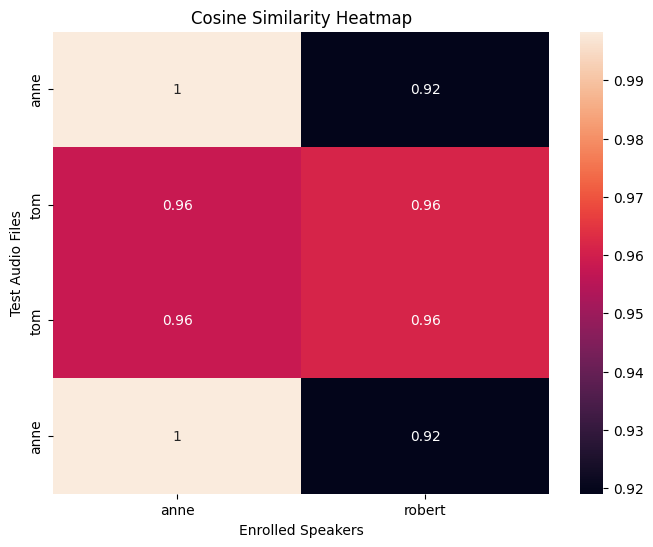

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

similarity_matrix = cosine_similarity(test_embeddings, enroll_embeddings)

plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, xticklabels=enroll_labels, yticklabels=test_file_names)
plt.title('Cosine Similarity Heatmap')
plt.xlabel('Enrolled Speakers')
plt.ylabel('Test Audio Files')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import librosa.display

def plot_mfcc(file_path, speaker_name):
    y, sr = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title(f'MFCCs of {speaker_name}')
    plt.tight_layout()
    plt.show()


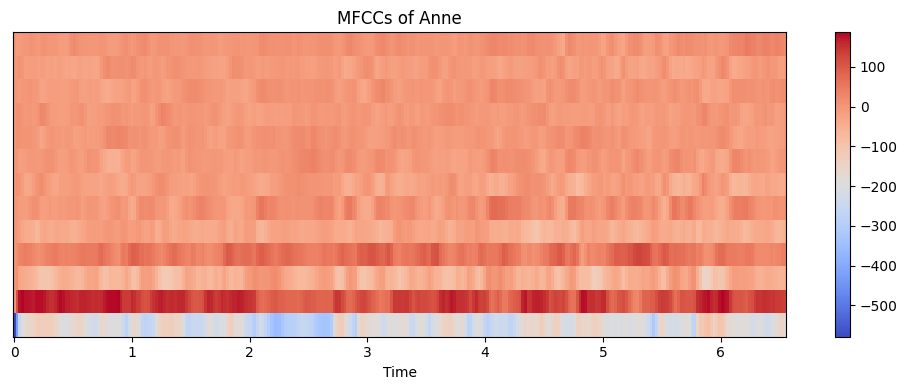

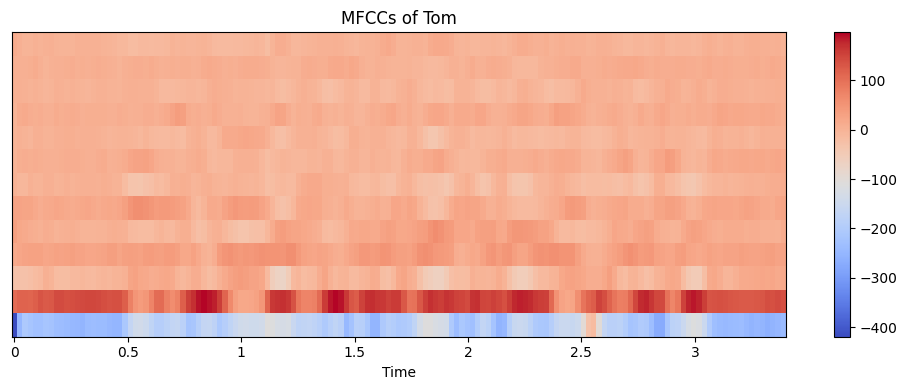

In [ ]:
plot_mfcc('anne_1.wav', 'Anne')
plot_mfcc('tom_1.wav', 'Tom')
